## Interface with `py_sc_fermi`

To extend the analysis available in doped, we include an optional interface with the [`py_sc_fermi`](https://github.com/bjmorgan/py-sc-fermi) code for analysis of self-consistent Fermi energies and defect concentrations. We'll go through how to use the interface to study defect concentrations in the CdTe.

### CdTe

The first step is simply to load in a `FermiSolver` object, this is a wrapper for a `py-sc-fermi` `DefectSystem` object and is designed so that you can generate these from your doped `DefectPhaseDiagram` objects.

In [1]:
from doped.interface.py_sc_fermi import FermiSolver
from monty.serialization import loadfn
import matplotlib.pyplot as plt

# we can use the doped style file to make the plots look consistent
style_file = "../doped/utils/doped.mplstyle"
plt.style.use(style_file)

# we need to specify the path to the vasprun.xml file
# that was used for the DOS calculation. This is because
# we need to accurately account for the electronic carrier concentrations
# as well as the defect concentrations
vasprun_path = "CdTe/CdTe_bulk/vasp_ncl/vasprun.xml.gz"

# the defect phase diagram contains all the information about the
# defect formation energies and transition levels. We'll use a version
# of the defect phase diagram that doesn't include the metastable states
# for the purposes of this example
thermodynamics = loadfn("CdTe/CdTe_thermo_v2.3_wout_meta.json")

# and the chemical potentials can then be used to specify the
# defect formation energies under different conditions, and act as a parameter
# space we can scan over to interrogate the defect concentrations
chemical_potentials = loadfn("CdTe/CdTe_chempots.json")

# initialize the FermiSolver object
fs = FermiSolver(defect_thermodynamics=thermodynamics, dos_vasprun=vasprun_path)

# we can then pick a chemical potential to use as a reference and generate the
# defect system from these chemical potentials, you can give any dictionary
# of chemical potentials that you like (key value pairs of elemental symbols 
# and chemical potentials), and the defect system will be generated
mu = chemical_potentials["facets"]["CdTe-Te"]
defect_system = fs.defect_system_from_chemical_potentials(chemical_potentials=mu)

# "defect_system.report()" then prints out the defect lots of information about the defect system
# including the defect concentrations, the Fermi level, and the carrier concentrations
defect_system.report()

Temperature :      300.0  (K)
SC Fermi level :      0.7488814331054696  (eV)
Concentrations:
n (electrons)  : 6511879.292940036 cm^-3
p (holes)      : 6511837.271526511 cm^-3
Te_i_Td_Te2.83      : 1.5682359618927004e-08 cm^-3, (percentage of defective sites: 4.58e-30 %)
Cd_i_Td_Te2.83      : 5.84421864707461e-16 cm^-3, (percentage of defective sites: 4.09e-36 %)
Cd_Te          : 6.02821057998202e-48 cm^-3, (percentage of defective sites: 4.22e-68 %)
Cd_i_Td_Cd2.83      : 4.685749378831632e-24 cm^-3, (percentage of defective sites: 3.28e-44 %)
Te_Cd          : 0.017510372796123518 cm^-3, (percentage of defective sites: 1.23e-22 %)
v_Te           : 8.699379222250187e-19 cm^-3, (percentage of defective sites: 6.09e-39 %)
v_Cd           : 0.43111267466836806 cm^-3, (percentage of defective sites: 3.02e-21 %)

Breakdown of concentrations for each defect charge state:
---------------------------------------------------------
Te_i_Td_Te2.83: Charge Concentration(cm^-3) Total
           : -1  

Once we have the base defect system inititalised, perhaps the simplest parameter to scan over is the temperature, and we can do so as follows,

In [2]:
# define a range of temperatures to scan over
import numpy as np
temp_range = np.arange(300, 1420, 20)

# the scan_temperature method can be used to scan over a range of temperatures
# and generate a DataFrame containing the defect concentrations, carrier concentrations,
# and Fermi levels at each temperature
temperature_df = fs.scan_temperature(mu, temp_range)

# print the generated DataFrame
print(temperature_df)


             Defect  Concentration  Temperature  Fermi Level
0                p0   6.511837e+06          300     0.748881
1                n0   6.511879e+06          300     0.748881
2    Te_i_Td_Te2.83   1.568236e-08          300     0.748881
3    Cd_i_Td_Te2.83   5.844219e-16          300     0.748881
4             Cd_Te   6.028211e-48          300     0.748881
..              ...            ...          ...          ...
499           Cd_Te   5.198867e+07         1400     0.722728
500  Cd_i_Td_Cd2.83   6.768750e+12         1400     0.722728
501           Te_Cd   3.373412e+17         1400     0.722728
502            v_Te   5.416718e+13         1400     0.722728
503            v_Cd   2.251868e+17         1400     0.722728

[504 rows x 4 columns]


Then with this information, we can simply plot the concentrations of different defects as a function of 
temperature. 

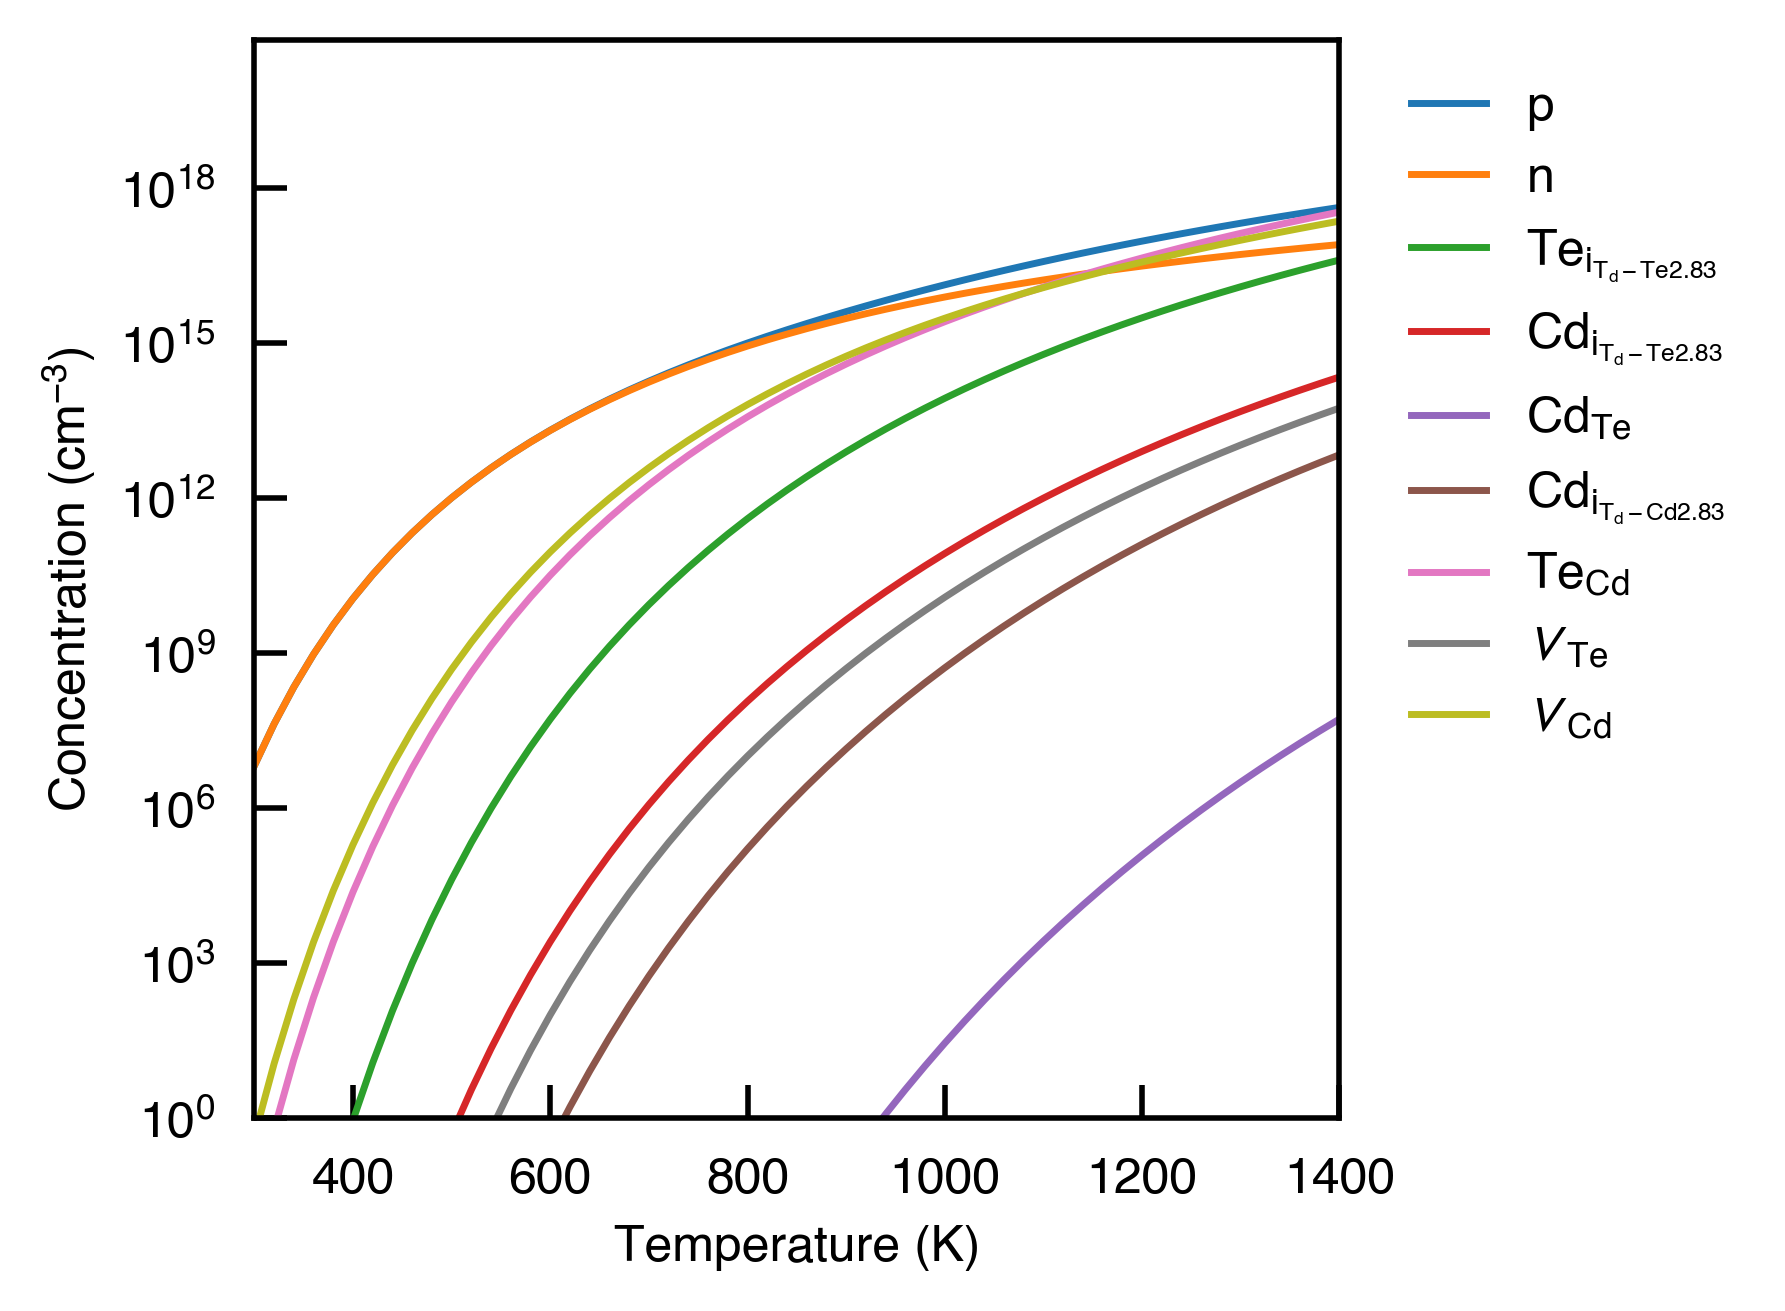

In [3]:
import matplotlib.pyplot as plt
from doped.utils.plotting import _format_defect_name

# Create a unique list of defects in the DataFrame
unique_defects = temperature_df['Defect'].unique()

# Loop through each unique defect and collect its concentrations to plot it
for defect in unique_defects:
    subset = temperature_df[temperature_df['Defect'] == defect]
    if defect == "p0": 
        label = "p"
    elif defect == "n0":
        label = "n"
    else:
        label = _format_defect_name(defect, include_site_info_in_name=True, wout_charge=True)
    plt.plot(subset['Temperature'], subset['Concentration'], label=label)

# More often than not, you will want to plot the concentrations on a log scale
plt.yscale('log')

# Add labels and title
plt.xlabel('Temperature (K)')
plt.ylabel(r'Concentration (cm$^{-3}$)')

# Add a legend to distinguish each defect type
plt.legend(frameon = False, bbox_to_anchor=(1.025, 1), loc='upper left')

# Show the plot
plt.ylim(1,None)
plt.xlim(temp_range[0], temp_range[-1])
plt.show()

Temperature :      300  (K)
SC Fermi level :      0.7488814331054696  (eV)
Concentrations:
n (electrons)  : 6511879.292940036 cm^-3
p (holes)      : 6511837.271526511 cm^-3
Te_i_Td_Te2.83      : 1.5682359618927004e-08 cm^-3 [fixed]
Cd_i_Td_Te2.83      : 5.84421864707461e-16 cm^-3 [fixed]
Cd_Te          : 6.02821057998202e-48 cm^-3 [fixed]
Cd_i_Td_Cd2.83      : 4.6857493788316316e-24 cm^-3 [fixed]
Te_Cd          : 0.017510372796123514 cm^-3 [fixed]
v_Te           : 8.69937922225019e-19 cm^-3 [fixed]
v_Cd           : 0.43111267466836806 cm^-3 [fixed]

Breakdown of concentrations for each defect charge state:
---------------------------------------------------------
Te_i_Td_Te2.83: Charge Concentration(cm^-3) Total
           : -1  1.474896e-39          0.00 
           : -2  5.836759e-80          0.00 
           :  0  1.568236e-08          100.00 
           :  1  1.287494e-16          0.00 
           :  2  6.539525e-29          0.00 
---------------------------------------------------

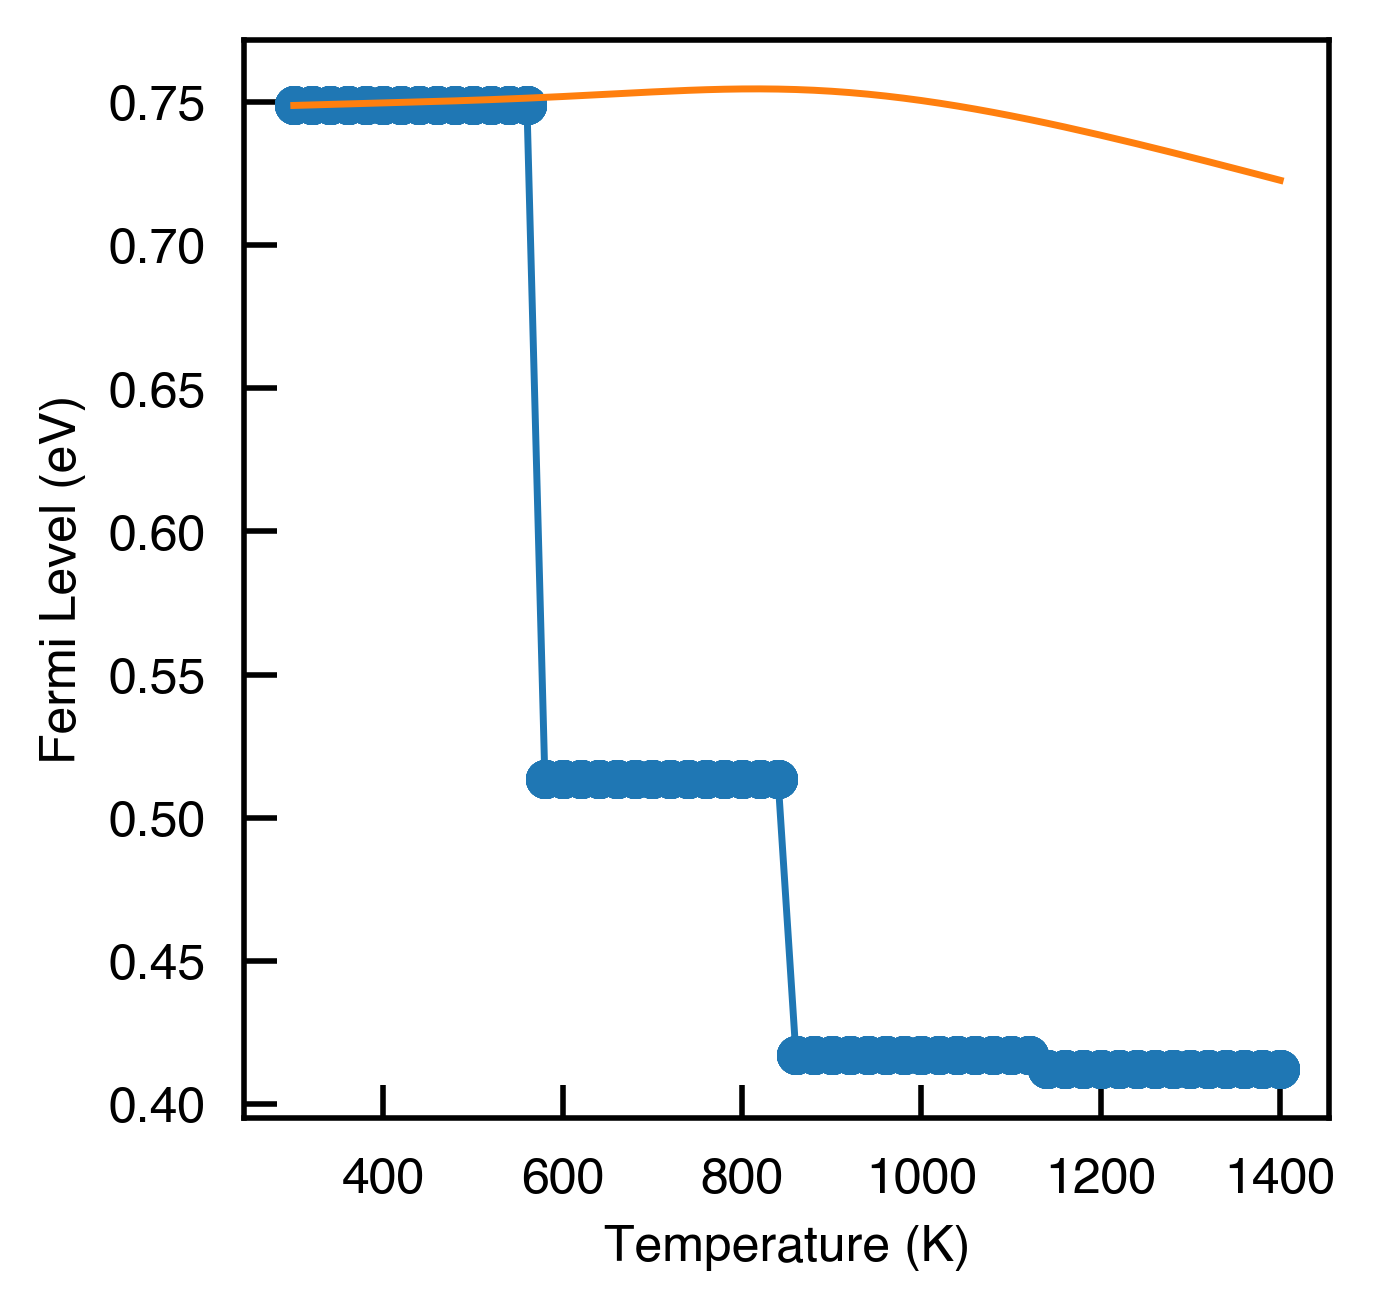

In [9]:
# define a range of temperatures to scan over
import numpy as np
temp_range = np.arange(300, 1420, 20)

# scan over the temperature range and save the results to a pandas DataFrame
ht_temperature_df = fs.scan_annealing_and_quench(mu, quenching_temperature=300, annealing_temperature_range=temp_range)

print(ht_temperature_df)

plt.plot(ht_temperature_df['Anneal Temperature'], ht_temperature_df['Fermi Level'], "-o")
plt.plot(temperature_df['Temperature'], temperature_df['Fermi Level'])

# plt.plot(hig)

plt.xlabel('Temperature (K)')
plt.ylabel('Fermi Level (eV)')
plt.show()

plt.show()

One thing we might be interested in CdTe is estimating the effect of annealing on carrier concentrations. We can also simulate different annealing effects by, for example, fixing the concentration of defects at high temperature and then recalculating the electron and hole concentrations at lower values.

Internally in `py-sc-fermi`, the way this works follows this process: 
 1. A DefectSystem object is generated at the annealing temperature, and the concentrations are calculated
 2. A new DefectSystem is generated at the lower temperature, in which the total concentration of each defect is fixed to the values calculated at high temperature
   (but the charge state is allowed to change)
    - note that specific defects can be excluded from this treatment using the `exceptions` argument in `scan_annealing_temperature`
    - in addition, the concentration of the defect charge states can be set directly using the argument `fix_defect_species` and setting 
      it to `False`
3. The second DefectSystem is calculated with these constraints applied, and the carrier concentrations and Fermi energy (and defect concentrations) are returned

This approach is highlighted in the cell below:

In [10]:
# define a range of temperatures to scan over
import numpy as np
temp_range = np.arange(300, 1420, 20)

# scan over the temperature range and save the results to a pandas DataFrame, this time however, we 
# vary the annealing temperature, and fix the temperature the temperature that the defect concentrations are
# calculated at finally. 
anneal_temperature_df = fs.scan_annealing_temperature(mu, 1000, temp_range)

fig, axs = plt.subplots(2, 1)

axs[0].plot(anneal_temperature_df["Anneal Temperature"], anneal_temperature_df["Fermi Level"], label = "temperature (annealing)")
axs[0].plot(temperature_df["Temperature"], temperature_df["Fermi Level"], label = "temperature")

# filter the DataFrames so that they contain only the carrier concentrations, 
holes = temperature_df[temperature_df["Defect"] == "p0"]
electrons = temperature_df[temperature_df["Defect"] == "n0"]

annealed_holes = anneal_temperature_df[anneal_temperature_df["Defect"] =="p0" ]
annealed_electrons = anneal_temperature_df[anneal_temperature_df["Defect"] =="n0"]

# plot the concentrations of electrons and holes as a function of temperature
axs[1].plot(holes["Temperature"], holes["Concentration"])
axs[1].plot(holes["Temperature"], electrons["Concentration"])

# plot the concentrations of electrons and holes as a function of the annealing temperature
axs[1].plot(annealed_holes["Anneal Temperature"], annealed_holes["Concentration"])
axs[1].plot(annealed_electrons["Anneal Temperature"], annealed_electrons["Concentration"])

# format the final plot
axs[0].set_ylabel("Fermi level (eV)")
axs[1].set_yscale("log")
axs[1].set_ylabel("Defect concentration (cm$^{-3}$)")
axs[1].set_xlabel("Temperature (K)")

plt.plot()


AttributeError: 'FermiSolver' object has no attribute 'scan_annealing_temperature'

In this next example, we'll scan over chemical potentials instead of temperature, and produce, in effect, a Brouwer diagram, scanning defect concentrations as we move from the Cd-rich chemical potential limit to the Td-rich chemical potential limit. We can do this with the `interpolate_chemical_potentials()` method of the `FermiSolver` object. This method works similarly to the previous temperature scanning methods, but requires us to enter a start and endpoint in chemical potential space, and then we calculate defect concentrations along a linear interpolation between these chemical potential sets. The number of points sampled along the linear interpolation is set by the `n_points` argument. Note that this function also accepts an `annealing_temperature` argument should you wish to include the effects of annealing in you chemical potential scan. 

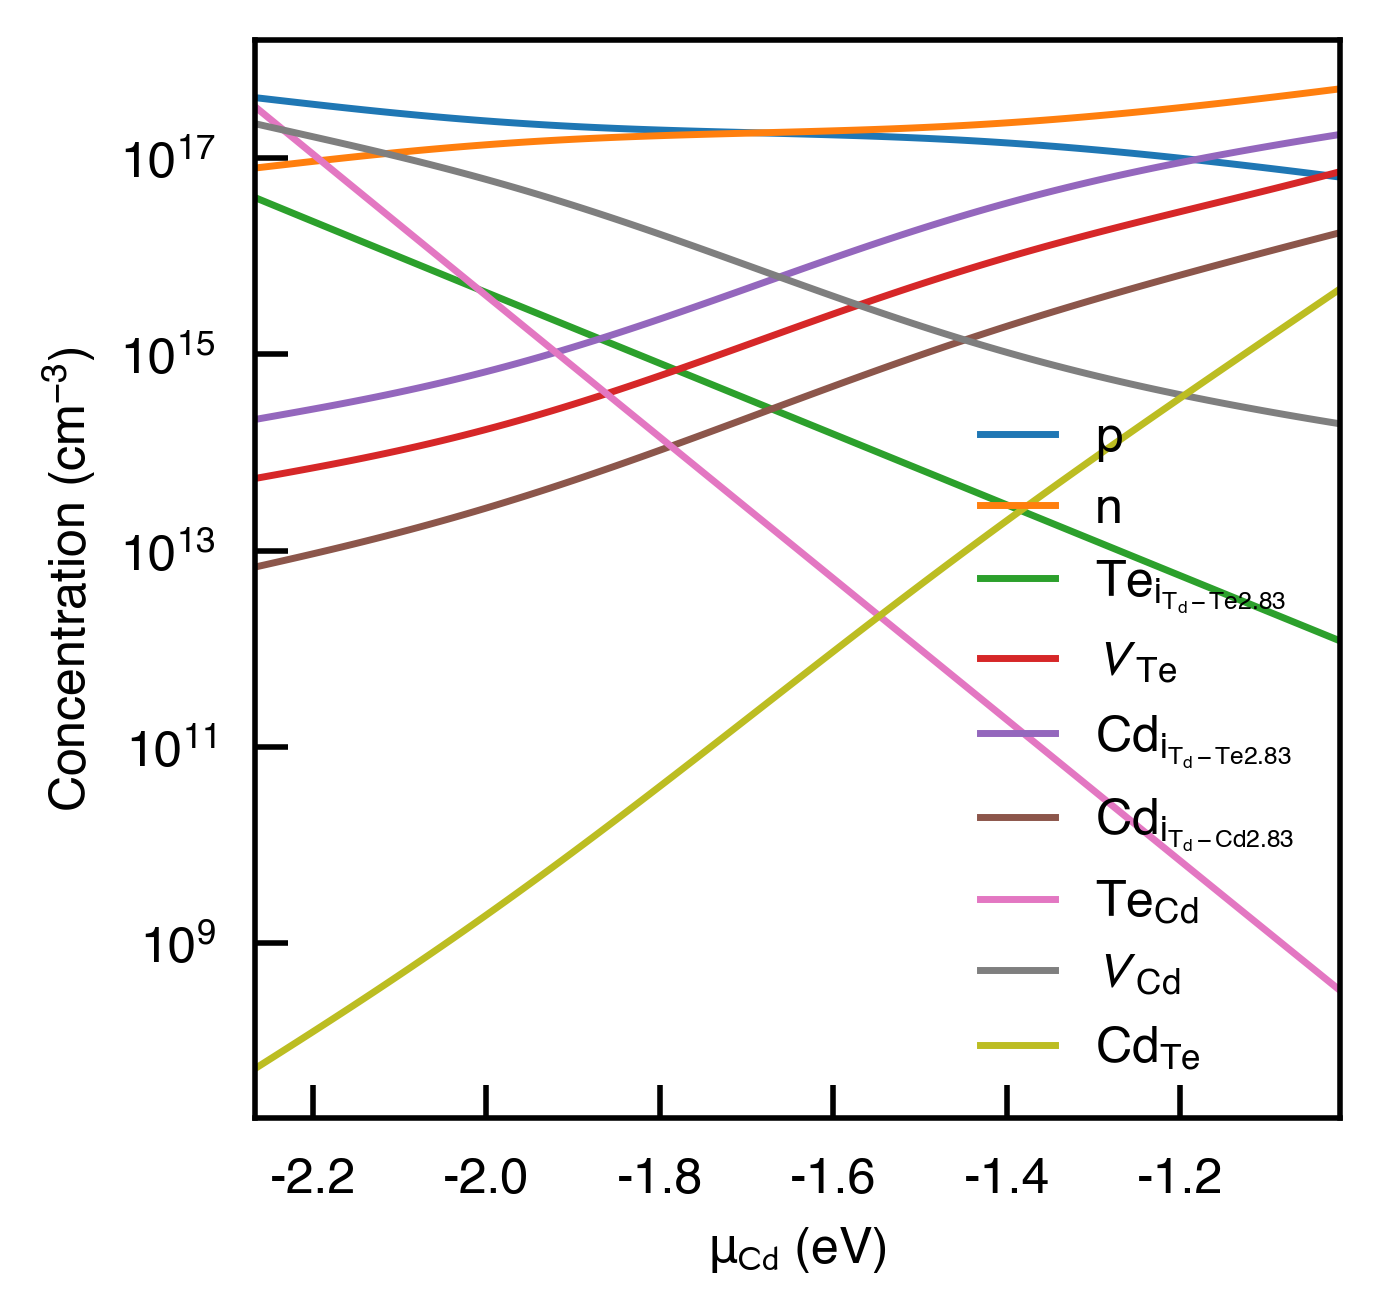

In [ ]:
# define a range of chemical potentials to scan over
chem_pot_df = fs.interpolate_chemical_potentials(chem_pot_start=chemical_potentials["facets"]["Cd-CdTe"],
                                                chem_pot_end=chemical_potentials["facets"]["CdTe-Te"],
                                                n_points=100, temperature=1400)

# Create a unique list of defects
unique_defects = chem_pot_df['Defect'].unique()

# Loop through each unique defect to collect its concentration as a function of
# the chemical potenials
for defect in unique_defects:
    subset = chem_pot_df[chem_pot_df['Defect'] == defect]
    if defect == "p0": 
        label = "p"
    elif defect == "n0":
        label = "n"
    else:
        label = _format_defect_name(defect, include_site_info_in_name=True, wout_charge=True)
    plt.plot(subset['Cd'], subset['Concentration'], label=label)
    
# Use a log scale on the y-axis due to the wide range of concentrations
plt.yscale('log')

# Add labels and title
plt.xlabel(r'$\mu_\mathrm{Cd}$ (eV)')
plt.ylabel('Concentration ($cm^{-3}$)')
plt.xlim(subset['Cd'].min(), subset['Cd'].max())

# Add a legend to distinguish each defect type
plt.legend(frameon = False)

# Show the plot
plt.show()

Of course this analysis can straight forwardly be extended to plotting the Fermi energy as a function of chemical potential:

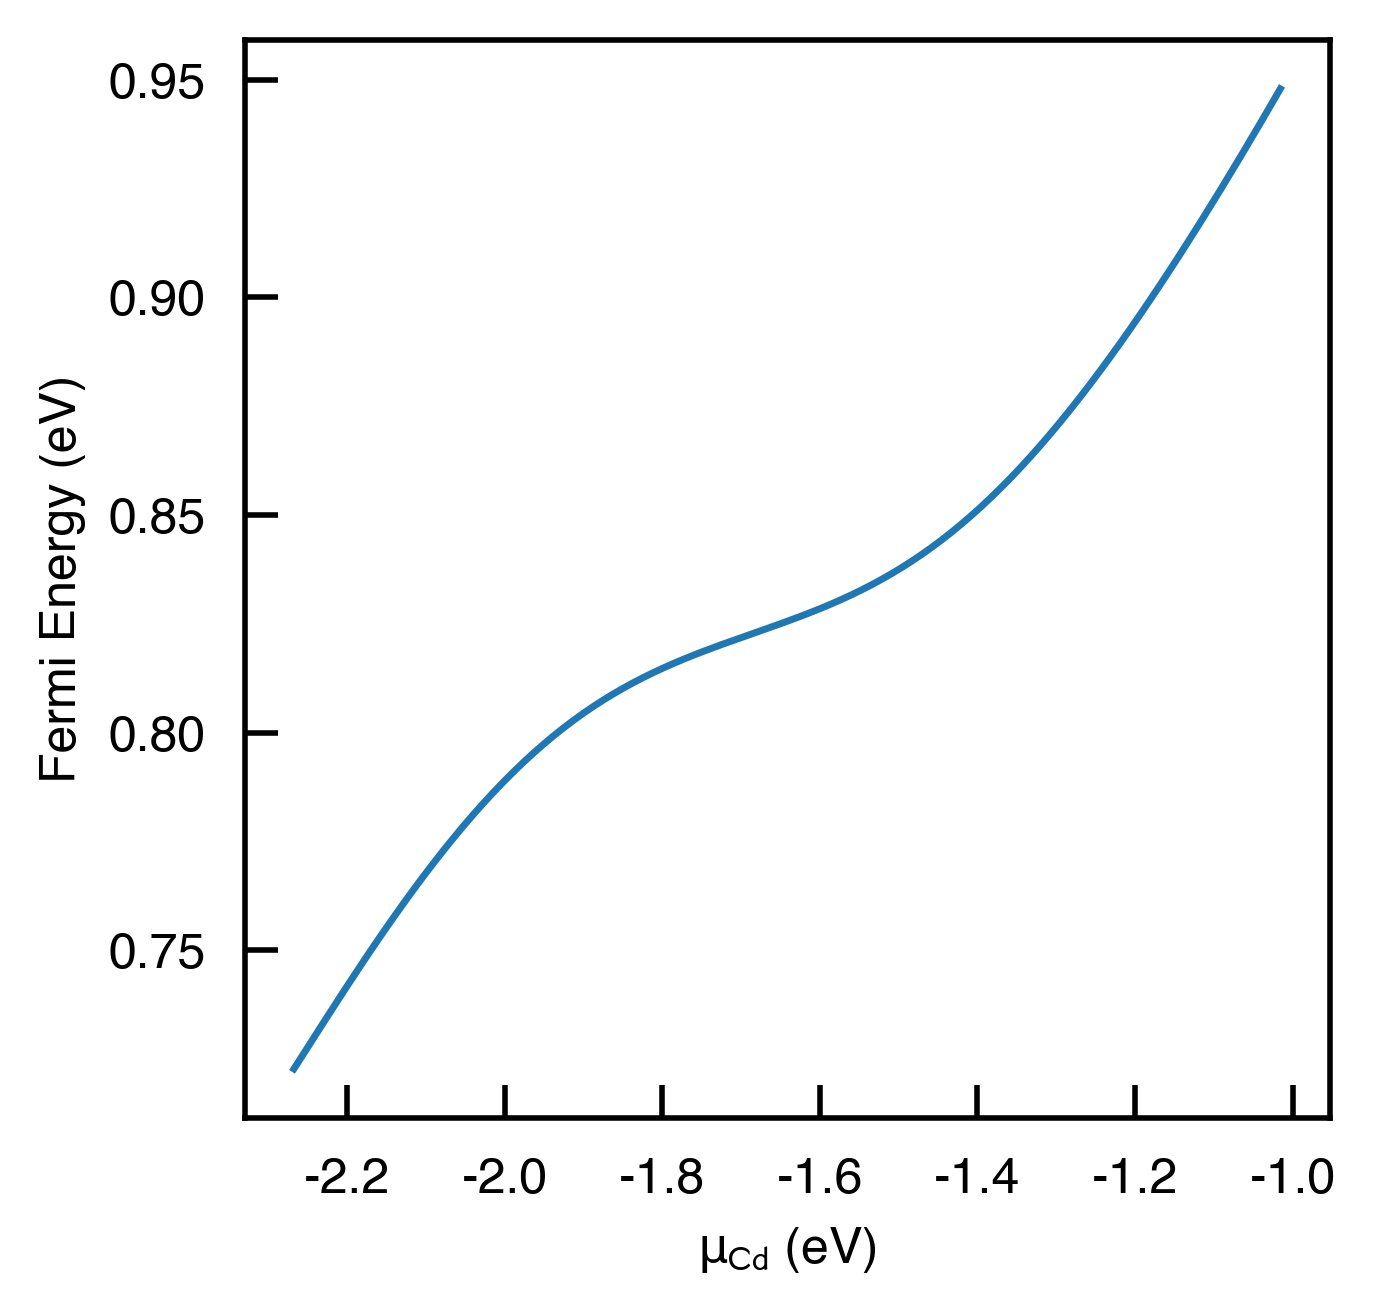

In [ ]:
plt.plot(chem_pot_df["Cd"], chem_pot_df["Fermi Level"])
plt.ylabel("Fermi Energy (eV)")
plt.xlabel(r'$\mu_\mathrm{Cd}$ (eV)')
plt.show()

Combining doped and py-sc-fermi also allows us to map different properties as a function of multiple parameters, here we shows the use of the the `interpolate_chemical_potentials_over_temperature_range()` method. This method is similar to the `interpolate_chemical_potentials` method, but accepts a temperature range rather than a single temperature. This can us the same annealing approach as other methods described with `annealing = True` and `cool_to` to add the final simulation temperature.

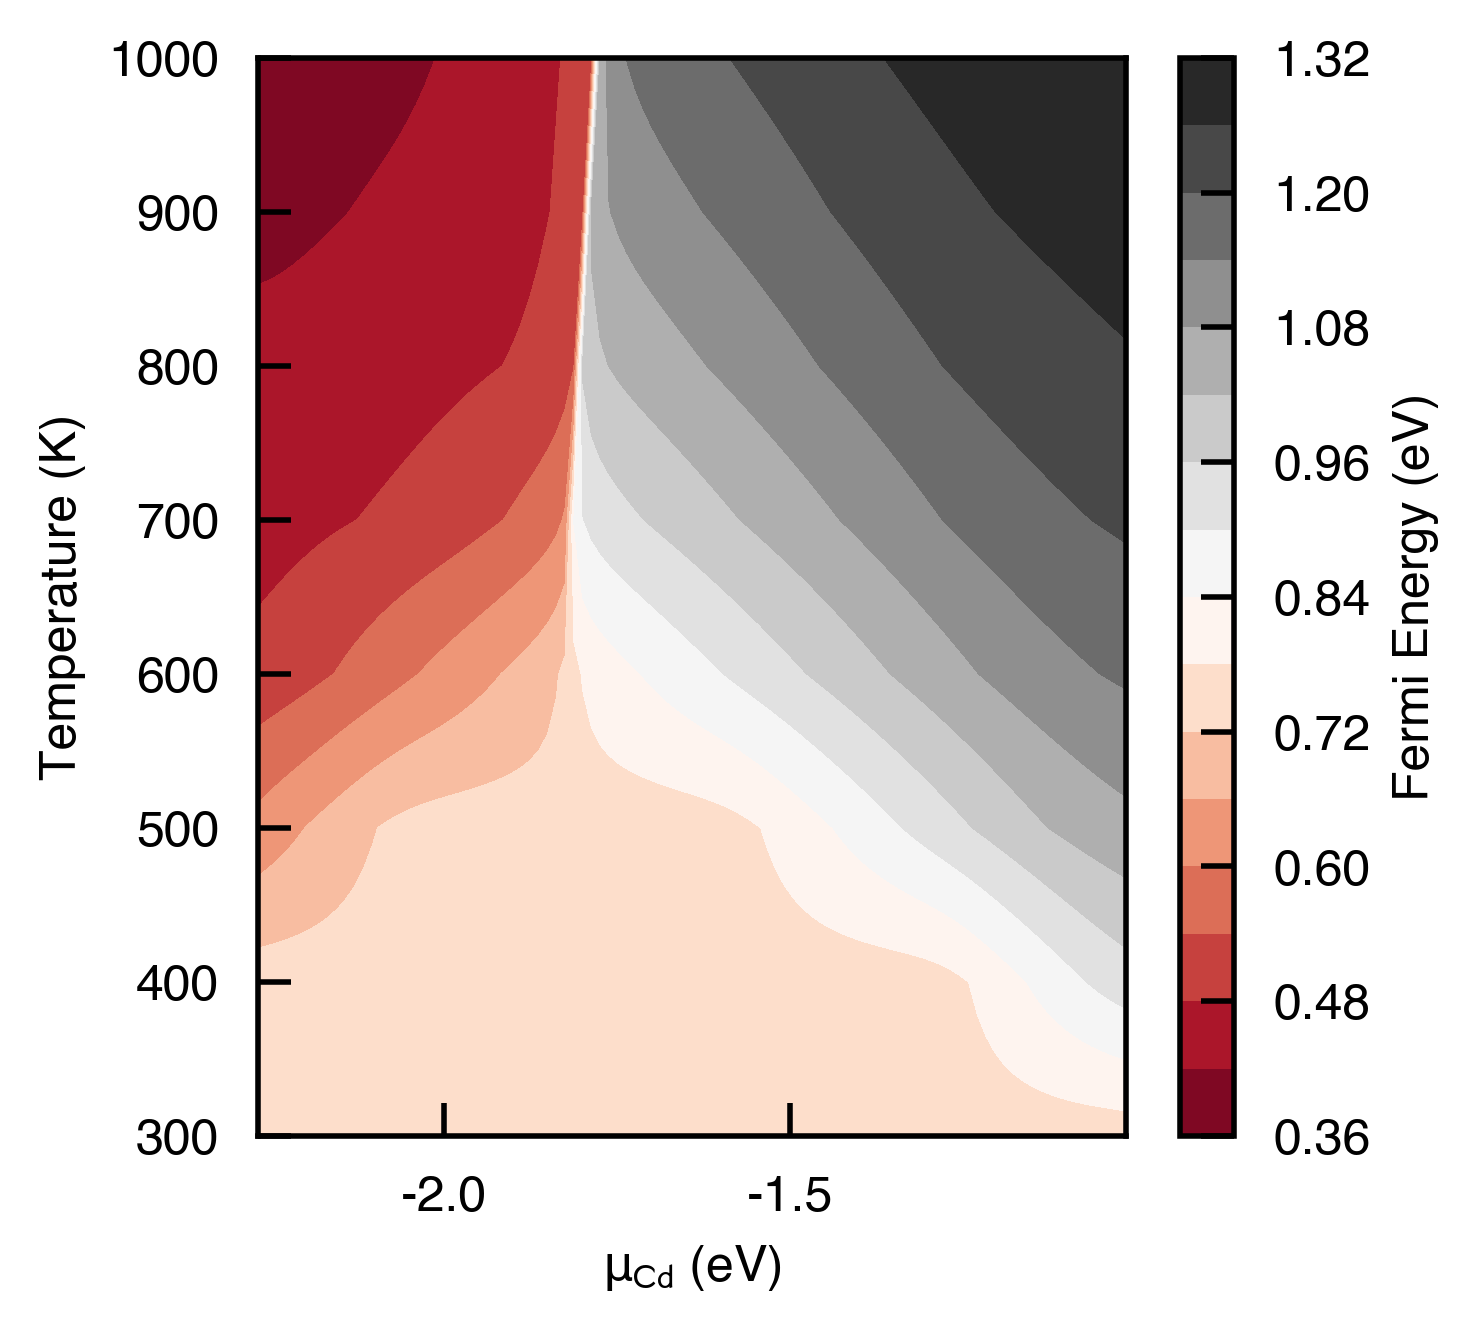

In [ ]:
# define a range of chemical potentials to scan over and a range of temperatures
df = fs.interpolate_chemical_potentials_over_temperature_range(chem_pot_start=chemical_potentials["facets"]["Cd-CdTe"],
                                                               chem_pot_end=chemical_potentials["facets"]["CdTe-Te"], 
                                                               n_points=100, 
                                                               temperature_range=[300, 400, 500, 600, 700, 800, 900, 1000], 
                                                               annealing=True, 
                                                               cool_to=300)

# Create a pivot table of the Fermi level as a function of the chemical potential and temperature
pivot_df = df.pivot_table(index='Temperature', columns='Cd', values='Fermi Level', aggfunc='max')

# Create a grid of (mu_Cd) and y (temperature) values
x = np.array(pivot_df.columns)
y = np.array(pivot_df.index)
X, Y = np.meshgrid(x, y)

# Create the contour plot

plt.xlabel(r'$\mu_\mathrm{Cd}$ (eV)')
plt.ylabel("Temperature (K)")

plt.contourf(X, Y, pivot_df.values, levels=15, cmap='RdGy')
plt.colorbar(label='Fermi Energy (eV)')
plt.show()